In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional, Flatten, TimeDistributed, Reshape
import tensorflow as tf


# **8:2**

In [2]:
df = pd.read_csv('BTC.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7.661248e+09
1,3/2/2019,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7.578786e+09
2,3/3/2019,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7.253558e+09
3,3/4/2019,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9.029176e+09
4,3/5/2019,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,1.017413e+10
...,...,...,...,...,...,...,...
1899,5/12/2024,60793.503910,61818.156250,60632.601560,61448.394530,61448.394530,1.380046e+10
1900,5/13/2024,61451.218750,63422.660160,60769.839840,62901.449220,62901.449220,2.788918e+10
1901,5/14/2024,62900.773440,63092.125000,61123.765630,61552.789060,61552.789060,2.818627e+10
1902,5/15/2024,61553.988280,66454.453130,61330.410160,66267.492190,66267.492190,3.981517e+10


In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define LSTM Model
# Define the CNN model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
23/23 [==============================] - 5s 103ms/step - loss: 0.0409 - val_loss: 0.0221
Epoch 2/200
23/23 [==============================] - 2s 91ms/step - loss: 0.0116 - val_loss: 0.0159
Epoch 3/200
23/23 [==============================] - 3s 117ms/step - loss: 0.0082 - val_loss: 0.0151
Epoch 4/200
23/23 [==============================] - 2s 68ms/step - loss: 0.0053 - val_loss: 0.0082
Epoch 5/200
23/23 [==============================] - 2s 67ms/step - loss: 0.0036 - val_loss: 0.0062
Epoch 6/200
23/23 [==============================] - 2s 68ms/step - loss: 0.0032 - val_loss: 0.0055
Epoch 7/200
23/23 [==============================] - 2s 66ms/step - loss: 0.0027 - val_loss: 0.0051
Epoch 8/200
23/23 [==============================] - 2s 68ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 9/200
23/23 [==============================] - 2s 66ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 10/200
23/23 [==============================] - 2s 105ms/step - loss: 0.0024 - val_loss: 0.0

In [10]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 13ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [12]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 1867.8650913762754
Testing MAPE: 2.672773579261596
Testing MAE: 1300.0279370513392


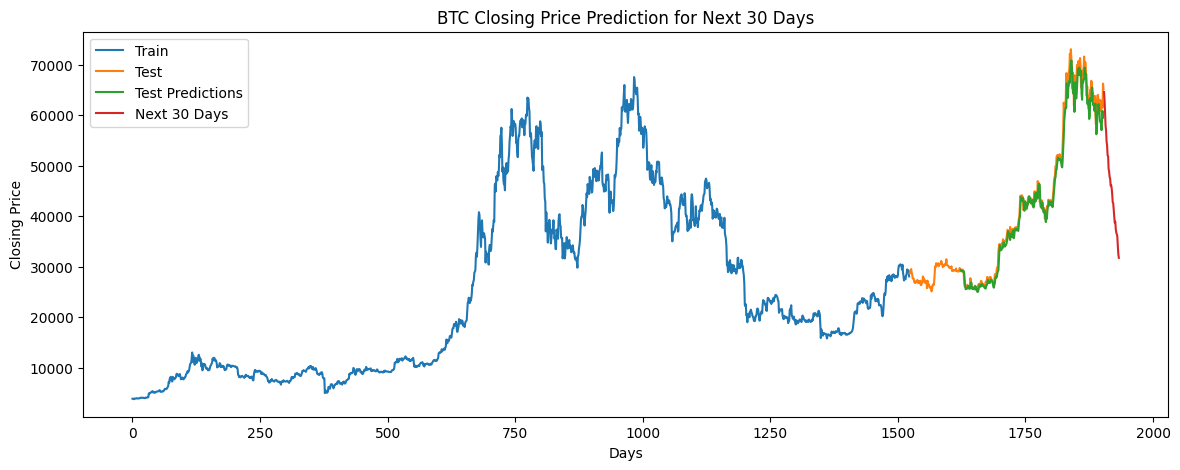

Predicted closing prices for the next 30 days:
[64611.008 62998.766 60591.16  57978.785 56975.516 54802.543 54021.04
 52059.395 51912.402 49339.844 48836.113 47753.207 47409.176 46044.652
 46192.73  45515.066 44392.15  42791.805 42575.99  41291.816 39924.348
 38694.414 38938.184 37442.24  36792.695 36440.09  36048.09  34108.367
 32514.334 31762.283]


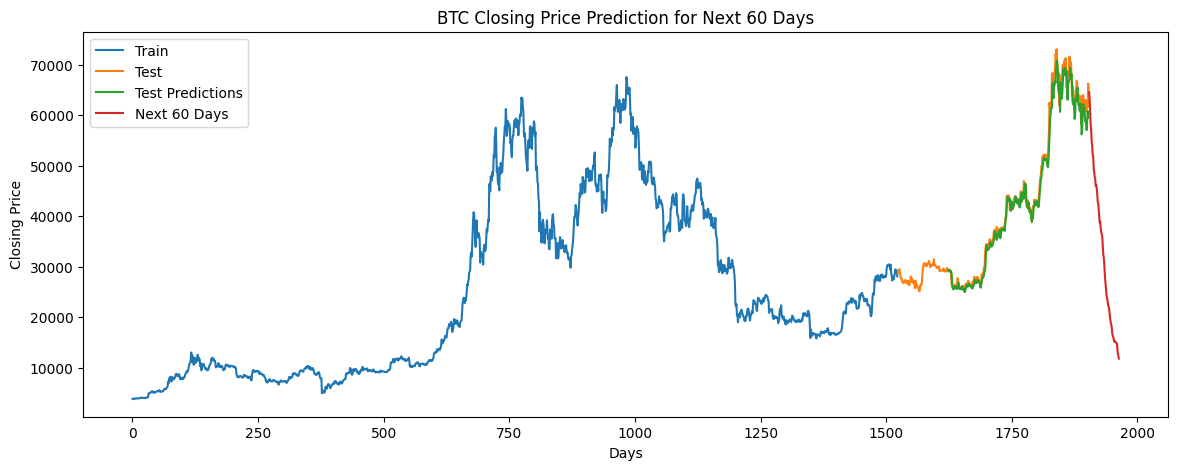

Predicted closing prices for the next 60 days:
[64611.008 62998.766 60591.16  57978.785 56975.516 54802.543 54021.04
 52059.395 51912.402 49339.844 48836.113 47753.207 47409.176 46044.652
 46192.73  45515.066 44392.15  42791.805 42575.99  41291.816 39924.348
 38694.414 38938.184 37442.24  36792.695 36440.09  36048.09  34108.367
 32514.334 31762.283 30584.734 28683.73  27264.6   26191.55  24938.805
 24027.303 23595.488 22962.9   22241.54  22080.328 21337.059 20389.91
 19495.521 18958.828 18524.678 17880.518 16715.959 16267.418 16028.57
 15567.943 15157.156 15307.936 15078.027 14989.756 14923.406 14821.997
 13948.693 12819.921 12382.506 11805.795]


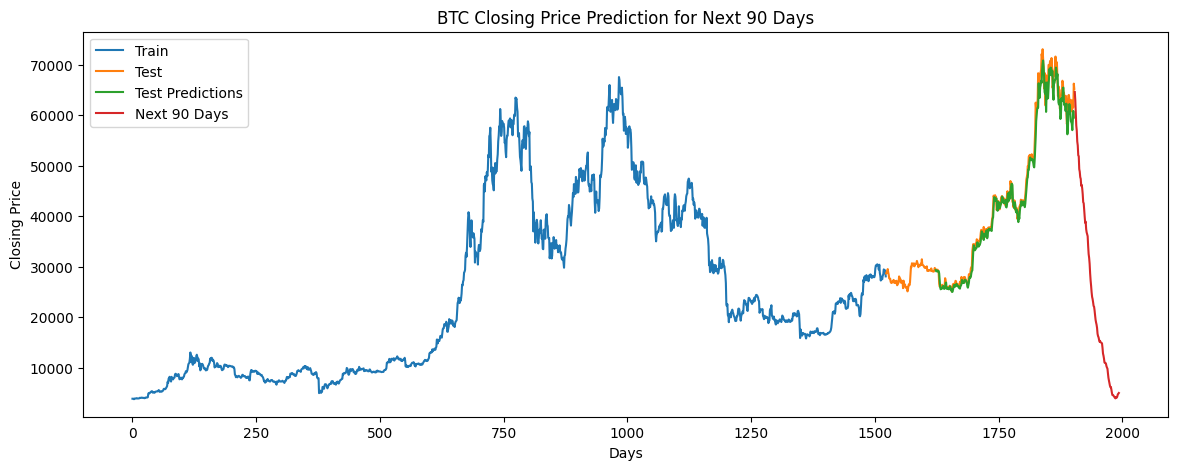

Predicted closing prices for the next 90 days:
[64611.008  62998.766  60591.16   57978.785  56975.516  54802.543
 54021.04   52059.395  51912.402  49339.844  48836.113  47753.207
 47409.176  46044.652  46192.73   45515.066  44392.15   42791.805
 42575.99   41291.816  39924.348  38694.414  38938.184  37442.24
 36792.695  36440.09   36048.09   34108.367  32514.334  31762.283
 30584.734  28683.73   27264.6    26191.55   24938.805  24027.303
 23595.488  22962.9    22241.54   22080.328  21337.059  20389.91
 19495.521  18958.828  18524.678  17880.518  16715.959  16267.418
 16028.57   15567.943  15157.156  15307.936  15078.027  14989.756
 14923.406  14821.997  13948.693  12819.921  12382.506  11805.795
 11025.698  10954.649  10954.919  10782.8545 10307.149  10025.433
  9821.696   8875.24    8003.5645  7454.8984  6956.154   6447.103
  6138.286   6167.7563  5639.9526  5023.9795  4585.6514  4582.645
  4490.0386  4356.7563  4208.705   4048.814   3934.878   4177.63
  4104.425   4094.0488  4364.073

In [13]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BTC Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **7:3**

In [14]:
df = pd.read_csv('BTC.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7.661248e+09
1,3/2/2019,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7.578786e+09
2,3/3/2019,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7.253558e+09
3,3/4/2019,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9.029176e+09
4,3/5/2019,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,1.017413e+10
...,...,...,...,...,...,...,...
1899,5/12/2024,60793.503910,61818.156250,60632.601560,61448.394530,61448.394530,1.380046e+10
1900,5/13/2024,61451.218750,63422.660160,60769.839840,62901.449220,62901.449220,2.788918e+10
1901,5/14/2024,62900.773440,63092.125000,61123.765630,61552.789060,61552.789060,2.818627e+10
1902,5/15/2024,61553.988280,66454.453130,61330.410160,66267.492190,66267.492190,3.981517e+10


In [15]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [17]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
20/20 [==============================] - 4s 94ms/step - loss: 0.0487 - val_loss: 0.0233
Epoch 2/200
20/20 [==============================] - 3s 130ms/step - loss: 0.0141 - val_loss: 0.0089
Epoch 3/200
20/20 [==============================] - 2s 82ms/step - loss: 0.0104 - val_loss: 0.0124
Epoch 4/200
20/20 [==============================] - 1s 71ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 5/200
20/20 [==============================] - 1s 71ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 6/200
20/20 [==============================] - 1s 71ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 7/200
20/20 [==============================] - 1s 71ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 8/200
20/20 [==============================] - 1s 71ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 9/200
20/20 [==============================] - 1s 72ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 10/200
20/20 [==============================] - 2s 115ms/step - loss: 0.0030 - val_loss: 0.00

In [22]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 13ms/step


In [23]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [24]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 1367.6602840743346
Testing MAPE: 2.2728290746851827
Testing MAE: 903.1446847810508


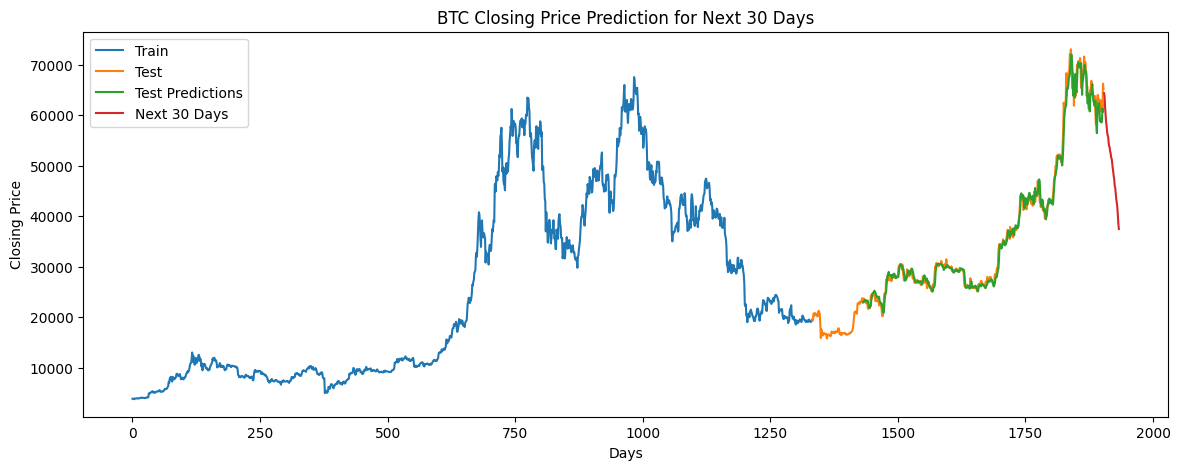

Predicted closing prices for the next 30 days:
[64369.543 63839.9   61629.582 60255.523 58756.582 57895.047 56774.69
 56042.82  55819.242 54636.355 53859.965 53666.5   52843.    52470.598
 51584.83  51405.582 50495.504 49573.44  48819.816 47943.73  47262.656
 45961.934 45612.035 44422.18  43361.33  42647.84  41857.098 40348.863
 38571.92  37467.32 ]


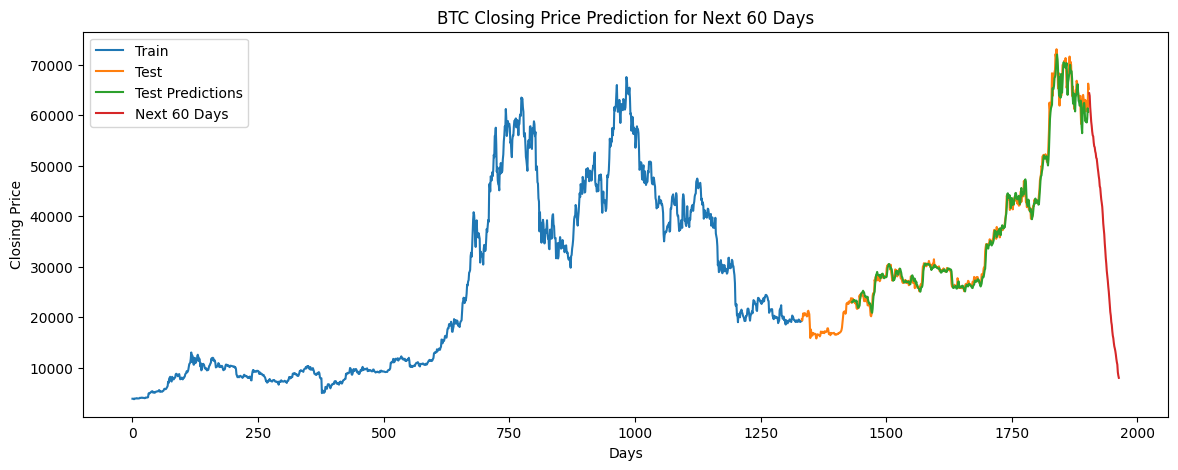

Predicted closing prices for the next 60 days:
[64369.543 63839.9   61629.582 60255.523 58756.582 57895.047 56774.69
 56042.82  55819.242 54636.355 53859.965 53666.5   52843.    52470.598
 51584.83  51405.582 50495.504 49573.44  48819.816 47943.73  47262.656
 45961.934 45612.035 44422.18  43361.33  42647.84  41857.098 40348.863
 38571.92  37467.32  36417.785 34643.938 33279.594 31736.977 30619.678
 29168.4   28206.496 27247.98  26049.627 25063.89  23758.861 22441.29
 21054.51  20312.168 19058.793 18455.45  17245.09  16360.585 15851.029
 14949.919 14229.927 13819.204 13310.595 12638.624 11793.368 11118.051
 10629.862  9107.362  8449.587  7995.09 ]


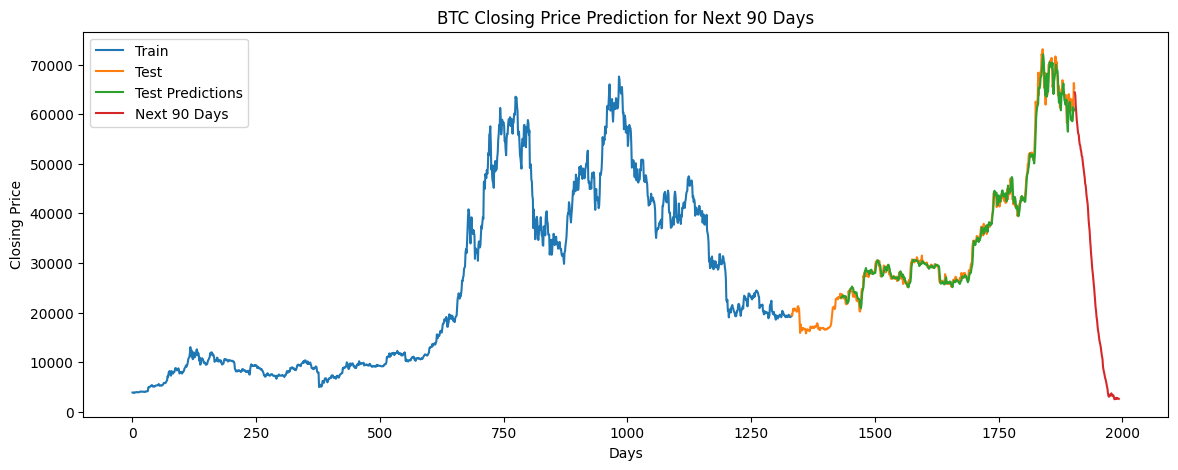

Predicted closing prices for the next 90 days:
[64369.543  63839.9    61629.582  60255.523  58756.582  57895.047
 56774.69   56042.82   55819.242  54636.355  53859.965  53666.5
 52843.     52470.598  51584.83   51405.582  50495.504  49573.44
 48819.816  47943.73   47262.656  45961.934  45612.035  44422.18
 43361.33   42647.84   41857.098  40348.863  38571.92   37467.32
 36417.785  34643.938  33279.594  31736.977  30619.678  29168.4
 28206.496  27247.98   26049.627  25063.89   23758.861  22441.29
 21054.51   20312.168  19058.793  18455.45   17245.09   16360.585
 15851.029  14949.919  14229.927  13819.204  13310.595  12638.624
 11793.368  11118.051  10629.862   9107.362   8449.587   7995.09
  7509.6978  6930.938   6590.146   6174.8115  5692.9995  5091.224
  4655.9233  3720.3083  3177.418   3023.9644  3262.4036  3186.219
  3533.5813  3430.9385  3707.3354  3352.0989  3158.6619  3189.658
  3325.5186  2927.0225  2525.7676  2515.7827  2638.9814  2618.9004
  2797.4766  2632.881   2745.843   26

In [25]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BTC Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **6:4**

In [27]:
df = pd.read_csv('BTC.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7.661248e+09
1,3/2/2019,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7.578786e+09
2,3/3/2019,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7.253558e+09
3,3/4/2019,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9.029176e+09
4,3/5/2019,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,1.017413e+10
...,...,...,...,...,...,...,...
1899,5/12/2024,60793.503910,61818.156250,60632.601560,61448.394530,61448.394530,1.380046e+10
1900,5/13/2024,61451.218750,63422.660160,60769.839840,62901.449220,62901.449220,2.788918e+10
1901,5/14/2024,62900.773440,63092.125000,61123.765630,61552.789060,61552.789060,2.818627e+10
1902,5/15/2024,61553.988280,66454.453130,61330.410160,66267.492190,66267.492190,3.981517e+10


In [29]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [30]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [31]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [32]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [33]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [34]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [35]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
17/17 [==============================] - 3s 93ms/step - loss: 0.0564 - val_loss: 0.0266
Epoch 2/200
17/17 [==============================] - 1s 78ms/step - loss: 0.0157 - val_loss: 0.0122
Epoch 3/200
17/17 [==============================] - 1s 76ms/step - loss: 0.0107 - val_loss: 0.0075
Epoch 4/200
17/17 [==============================] - 1s 78ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 5/200
17/17 [==============================] - 2s 102ms/step - loss: 0.0060 - val_loss: 0.0071
Epoch 6/200
17/17 [==============================] - 2s 139ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 7/200
17/17 [==============================] - 2s 88ms/step - loss: 0.0038 - val_loss: 0.0080
Epoch 8/200
17/17 [==============================] - 1s 75ms/step - loss: 0.0032 - val_loss: 0.0090
Epoch 9/200
17/17 [==============================] - 1s 77ms/step - loss: 0.0031 - val_loss: 0.0099
Epoch 10/200
17/17 [==============================] - 1s 76ms/step - loss: 0.0030 - val_loss: 0.00

In [36]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 17ms/step


In [37]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [38]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 0.0718566947976433
Testing MAPE: 20.297528643105395
Testing MAE: 0.06352637351718574


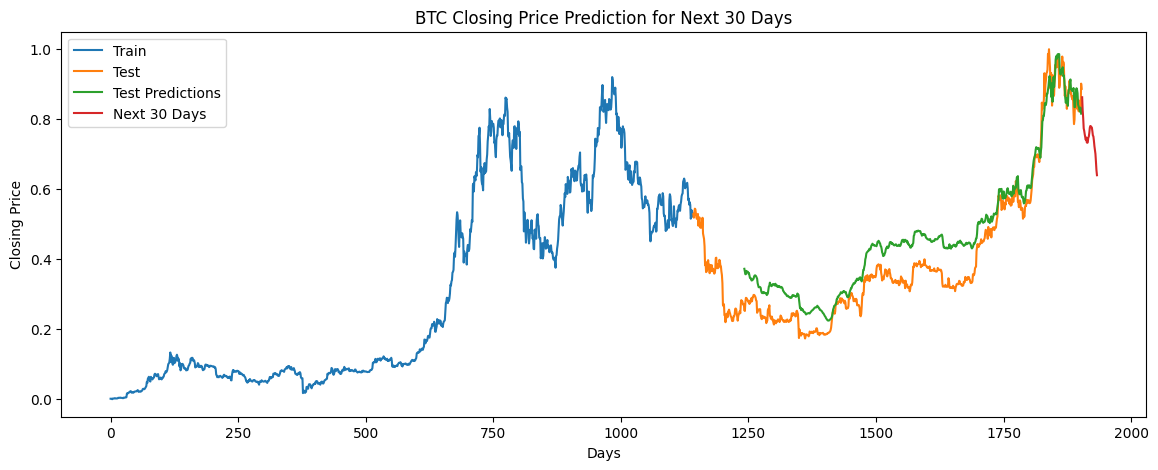

Predicted closing prices for the next 30 days:
[0.86276776 0.8257463  0.80381775 0.77392846 0.76700044 0.75715595
 0.74897367 0.7411944  0.74749404 0.7340563  0.7326491  0.7337265
 0.7473695  0.750202   0.76081425 0.7755149  0.78072697 0.779925
 0.7773917  0.7764364  0.7658     0.7536649  0.7508778  0.7387995
 0.7233957  0.7122256  0.7011774  0.6788716  0.65461606 0.6399961 ]


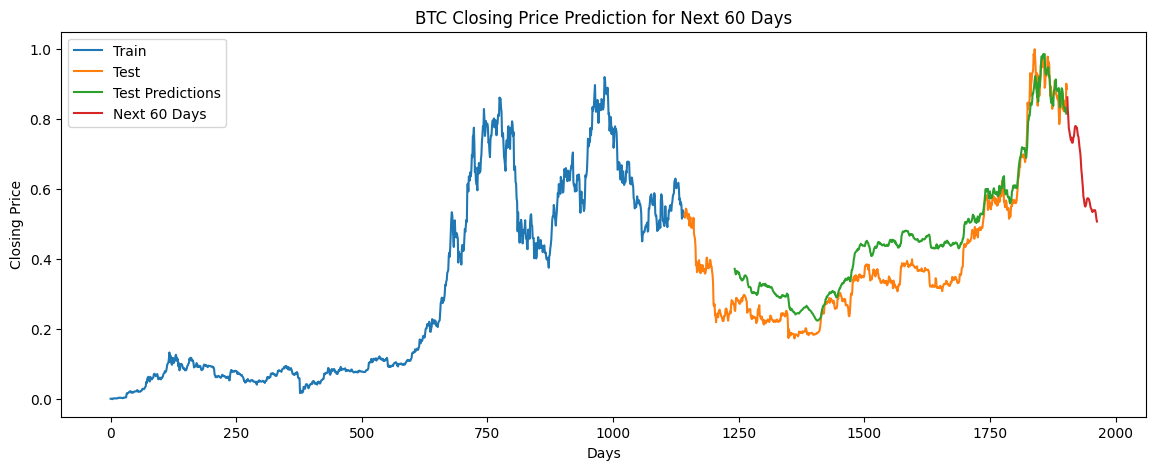

Predicted closing prices for the next 60 days:
[0.86276776 0.8257463  0.80381775 0.77392846 0.76700044 0.75715595
 0.74897367 0.7411944  0.74749404 0.7340563  0.7326491  0.7337265
 0.7473695  0.750202   0.76081425 0.7755149  0.78072697 0.779925
 0.7773917  0.7764364  0.7658     0.7536649  0.7508778  0.7387995
 0.7233957  0.7122256  0.7011774  0.6788716  0.65461606 0.6399961
 0.6216337  0.6043826  0.57917607 0.5721639  0.55970985 0.5517198
 0.5503672  0.5549571  0.561247   0.5714055  0.5736099  0.5745107
 0.5724082  0.5715867  0.56547165 0.5598801  0.5500799  0.5457291
 0.54324615 0.5380796  0.5348586  0.53647393 0.53983694 0.53924805
 0.53976053 0.5404981  0.53629106 0.52627087 0.5144525  0.5078052 ]


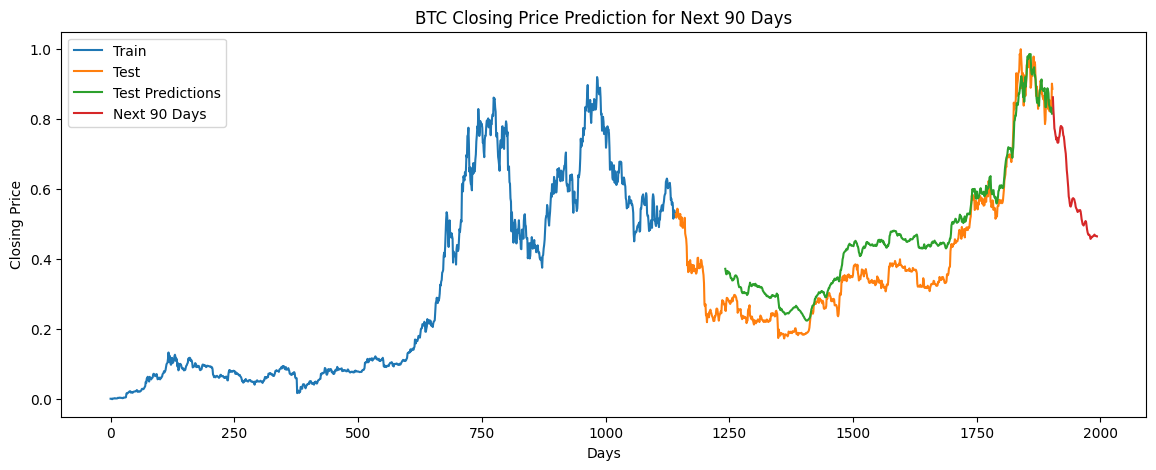

Predicted closing prices for the next 90 days:
[0.86276776 0.8257463  0.80381775 0.77392846 0.76700044 0.75715595
 0.74897367 0.7411944  0.74749404 0.7340563  0.7326491  0.7337265
 0.7473695  0.750202   0.76081425 0.7755149  0.78072697 0.779925
 0.7773917  0.7764364  0.7658     0.7536649  0.7508778  0.7387995
 0.7233957  0.7122256  0.7011774  0.6788716  0.65461606 0.6399961
 0.6216337  0.6043826  0.57917607 0.5721639  0.55970985 0.5517198
 0.5503672  0.5549571  0.561247   0.5714055  0.5736099  0.5745107
 0.5724082  0.5715867  0.56547165 0.5598801  0.5500799  0.5457291
 0.54324615 0.5380796  0.5348586  0.53647393 0.53983694 0.53924805
 0.53976053 0.5404981  0.53629106 0.52627087 0.5144525  0.5078052
 0.4999424  0.4993369  0.49624166 0.5005019  0.50250775 0.50575775
 0.5091292  0.50639737 0.49570477 0.48511177 0.47743776 0.472034
 0.4694616  0.4704251  0.46892017 0.4648021  0.45810097 0.4598102
 0.4641182  0.46289715 0.46418458 0.46588024 0.46632907 0.46847466
 0.4703236  0.467643   0.46

In [39]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BTC Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())